# Week 5: Support Vector Machines
Include concepts such as support vector machines, the kernel trick, and regularization for support vector machines.

In [1]:
# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
import kagglehub
from urllib.parse import urlparse
from itertools import chain, combinations
from collections import Counter
import re

# Data Science Libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import seaborn as sns

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold,
    RepeatedStratifiedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn import decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_recall_curve,
    accuracy_score,
    mean_squared_error,
    classification_report
)
from sklearn.pipeline import make_pipeline


# Progress Tracking
from tqdm import tqdm

# Language Processing
from textblob import TextBlob
from datetime import datetime, timedelta
import string

# globals
random_state = 42

In [2]:
def split_scale(model_class=None, X=None, y=None, test_size=0.2, random_state=42, **model_params):
    # Error handling
    if model_class is None:
        raise ValueError('Please provide a model class not the instance.')
    if X is None or y is None:
        raise ValueError('You must provide features and target for model building.')

    # Split data into train and test data subsets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Scale the features
    model = make_pipeline(
        StandardScaler(),
        model_class(**model_params)
    )

    return X_train, X_test, y_train, y_test, model



def visualize_classification_results(y_test, y_pred, y_proba=None):
    class_names = np.unique(y_test)

    # Set up the plotting grid
    plt.figure(figsize=(16, 4))

    # Plot Confusion Matrix
    plt.subplot(1, 3, 1)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', colorbar=False, ax=plt.gca())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    if y_proba is not None and len(class_names) == 2:
        plt.subplot(1, 3, 2)
        fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()

        plt.subplot(1, 3, 3)
        precision, recall, _ = precision_recall_curve(y_test, y_proba[:, 1])
        plt.plot(recall, precision)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')

    plt.tight_layout()
    plt.show()



def run_classification_model(model, X_train, X_test, y_train, y_test, n_repeats=5, n_jobs=-1, confusion=False, **model_params):

    # Cross-validation setup
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=n_jobs)
    
    # Fit model on full training set
    model.fit(X_train, y_train)
    
    # Predictions
    train_preds = model.predict(X_train)
    y_preds = model.predict(X_test)

    # Check if predict_proba is an attribute
    y_proba = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
    
    # Metrics
    results = {
        "mean_cv_accuracy": np.mean(cv_scores),
        "std_cv_accuracy": np.std(cv_scores),
        "train_accuracy": accuracy_score(y_train, train_preds),
        "test_accuracy": accuracy_score(y_test, y_preds),
    }

    print(f"Mean CV Accuracy: {results['mean_cv_accuracy']:.4f}",
        f"\nStd CV Accuracy: {results['std_cv_accuracy']:.4f}",
        f"\nTrain Accuracy: {results['train_accuracy']:.4f}",
        f"\nTest Accuracy: {results['test_accuracy']:.4f}"
        )

    # Optionally add confusion matrices
    if confusion:
        results["confusion_train"] = confusion_matrix(y_train, train_preds)
        results["confusion_test"] = confusion_matrix(y_test, y_preds)
        visualize_classification_results(y_test, y_preds, y_proba)

    return results


def visualize_regression_results(y_test, y_pred):
    # Calculate residuals
    residuals = y_test - y_pred

    # Set up the plotting grid
    plt.figure(figsize=(16, 4))

    # Plot Predicted vs. Actual
    plt.subplot(1, 3, 1)
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Fit')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predicted vs. Actual')
    plt.legend()

    # Plot Residuals vs. Predicted
    plt.subplot(1, 3, 2)
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs. Predicted')

    # Plot Residual Distribution
    plt.subplot(1, 3, 3)
    sns.histplot(residuals, kde=True, color='gray')
    plt.xlabel('Residuals')
    plt.title('Residual Distribution')

    plt.tight_layout()
    plt.show()



def run_regression_model(model, X_train, X_test, Y_train, Y_test, n_repeats=5, n_jobs=-1, visual=False, **model_params):

    # Cross-validation setup
    cv = RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=cv, n_jobs=n_jobs)
    
    # Fit model on full training set
    model.fit(X_train, y_train)
    
    # Predictions
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    # Metrics
    results = {
        "mean_cv_r2": np.mean(cv_scores),
        "std_cv_r2": np.std(cv_scores),
        "train_r2": r2_score(y_train, train_preds),
        "test_r2": r2_score(y_test, test_preds),
        "train_mae": mean_absolute_error(y_train, train_preds),
        "test_mae": mean_absolute_error(y_test, test_preds),
        "train_rmse": np.sqrt(mean_squared_error(y_train, train_preds)),
        "test_rmse": np.sqrt(mean_squared_error(y_test, test_preds))
    }

    # Print summary
    print(
        f"Mean CV R^2: {results['mean_cv_r2']:.4f}",
        f"\nStd CV R^2: {results['std_cv_r2']:.4f}",
        f"\nTrain R^2: {results['train_r2']:.4f}",
        f"\nTest R^2: {results['test_r2']:.4f}",
        f"\nTrain RMSE: {results['train_rmse']:.4f}",
        f"\nTest RMSE: {results['test_rmse']:.4f}"
    )

    if visual is True:
        visualize_regression_results(y_test, y_pred)

    return results


## Dataset 1: Web Page Phishing Detection

In [3]:
# Load cleaned data
cleaned_webpage = pd.read_csv('cleaned_webpage.csv')
cleaned_webpage.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,legitimate
0,37,19,0,3,0,0,0,0,0,0,...,0,1,0,45,0,0,1,1,4,1
1,77,23,1,1,0,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,0
2,126,50,1,4,1,0,1,2,0,3,...,1,0,0,14,4004,5828815,0,1,0,0
3,18,11,0,2,0,0,0,0,0,0,...,1,0,0,62,0,107721,0,0,3,1
4,55,15,0,2,2,0,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,1


In [4]:
# Define X (features) and y (target value)
X = cleaned_webpage.drop(columns=['legitimate'])
y = cleaned_webpage['legitimate']

Mean CV Accuracy: 0.9426 
Std CV Accuracy: 0.0038 
Train Accuracy: 0.9481 
Test Accuracy: 0.9589


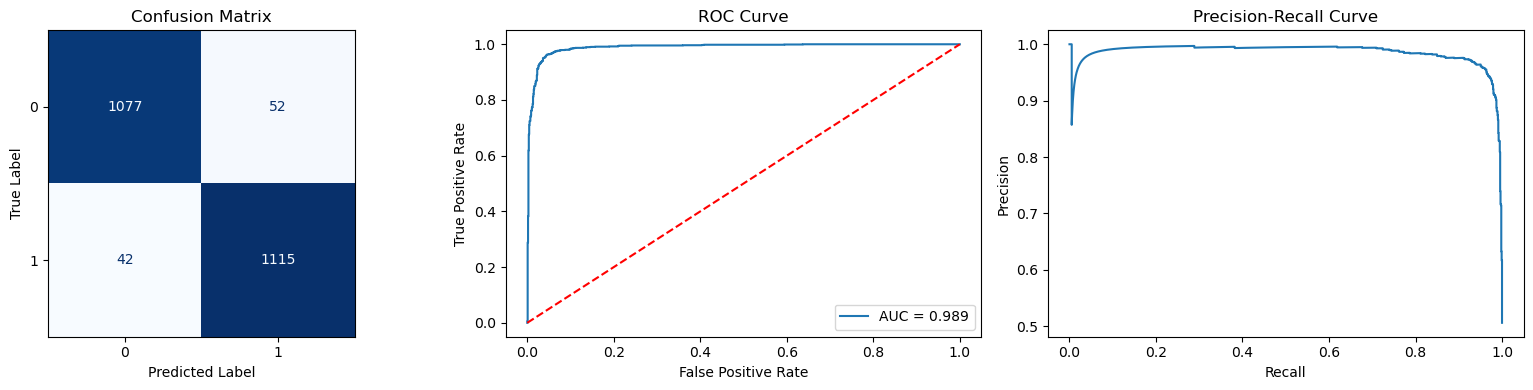

In [5]:
params = {'kernel': 'linear',
    'C': 1.0,
    'probability': True
}

X_train, X_test, y_train, y_test, model = split_scale(SVC, X, y, **params)
results = run_classification_model(model, X_train, X_test, y_train, y_test, confusion=True)

## Dataset 2: Phishing Email Detection

In [6]:
# Load cleaned data
cleaned_email = pd.read_csv('cleaned_phishing_email.csv')
cleaned_email.head()

,polarity,subjectivity,unique_words,char_count,word_count,uppercase_ratio,symbol_ratio,kw_urgent,kw_verify,kw_account,kw_click,kw_suspend,kw_update,kw_login,kw_confirm,currency_symbol_count,phone_number_count,Safe Email
0,0.201493,0.514213,110.0,1030.0,230.0,0.000000,0.059223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.009375,0.084375,53.0,479.0,91.0,0.000000,0.037578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.091540,0.515783,102.0,1245.0,305.0,0.000000,0.077108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.260069,0.690278,73.0,688.0,96.0,0.056686,0.162791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0
4,0.152579,0.505258,60.0,441.0,91.0,0.000000,0.061224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [8]:
# Define X (features) and y (target value)
X2 = cleaned_email.drop(columns=['Safe Email'])
y2 = cleaned_email['Safe Email']

Mean CV Accuracy: 0.7133 
Std CV Accuracy: 0.0049 
Train Accuracy: 0.7132 
Test Accuracy: 0.6998


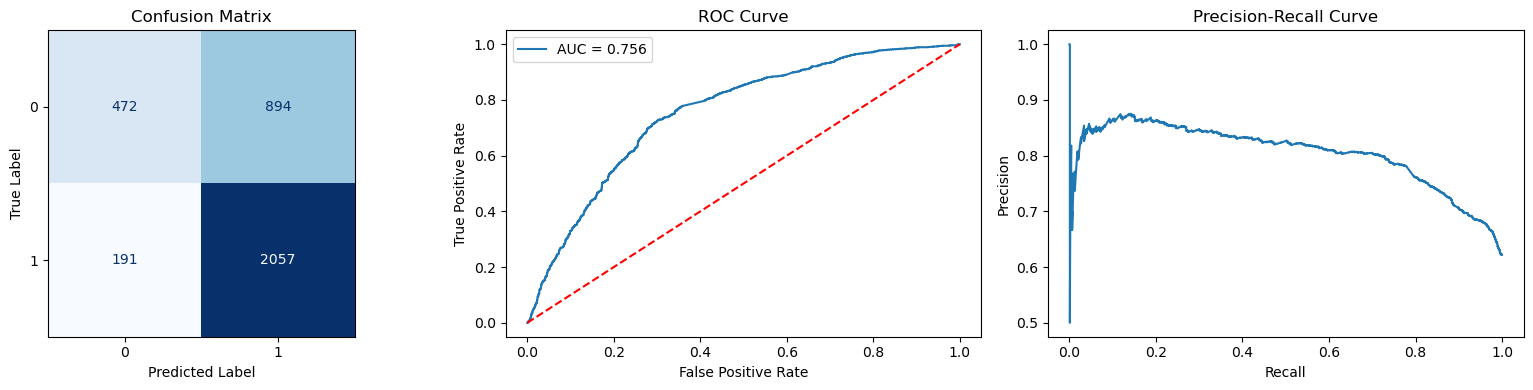

In [11]:
params2 = {'kernel': 'linear',
    'C': 1.0,
    'probability': True
}

X2_train, X2_test, y2_train, y2_test, model2 = split_scale(SVC, X2, y2, **params2)
results2 = run_classification_model(model2, X2_train, X2_test, y2_train, y2_test, confusion=True)

## Dataset 3: Credit Card Transactions Fraud Detection Dataset

In [16]:
# Load cleaned data
cleaned_credit_card = pd.read_csv('cleaned_credit_card.csv')
cleaned_credit_card.head()

,category,amt,gender,city,state,lat,long,city_pop,job,unix_time,merch_lat,merch_long,age,max_repeats,is_fraud
0,0,2.86,0,0,0,33.9659,-80.9355,333497,0,1371816865,33.986391,-81.200714,57,3,0
1,0,29.84,1,1,1,40.3207,-110.4360,302,1,1371816873,39.450498,-109.960431,35,4,0
2,1,41.28,1,2,2,40.6729,-73.5365,34496,2,1371816893,40.495810,-74.196111,54,4,0
3,2,60.05,0,3,3,28.5697,-80.8191,54767,3,1371816915,28.812398,-80.883061,38,4,0
4,3,3.19,0,4,4,44.2529,-85.0170,1126,4,1371816917,44.959148,-85.884734,70,3,0


In [19]:
# Pull a random subset of the data to use
df_sample = cleaned_credit_card.sample(n=4000, random_state=42)

# Define X (features) and y (target value)
X3 = df_sample.drop(columns=['is_fraud'])
y3 = df_sample['is_fraud']

Mean CV Accuracy: 0.9934 
Std CV Accuracy: 0.0006 
Train Accuracy: 0.9934 
Test Accuracy: 0.9938


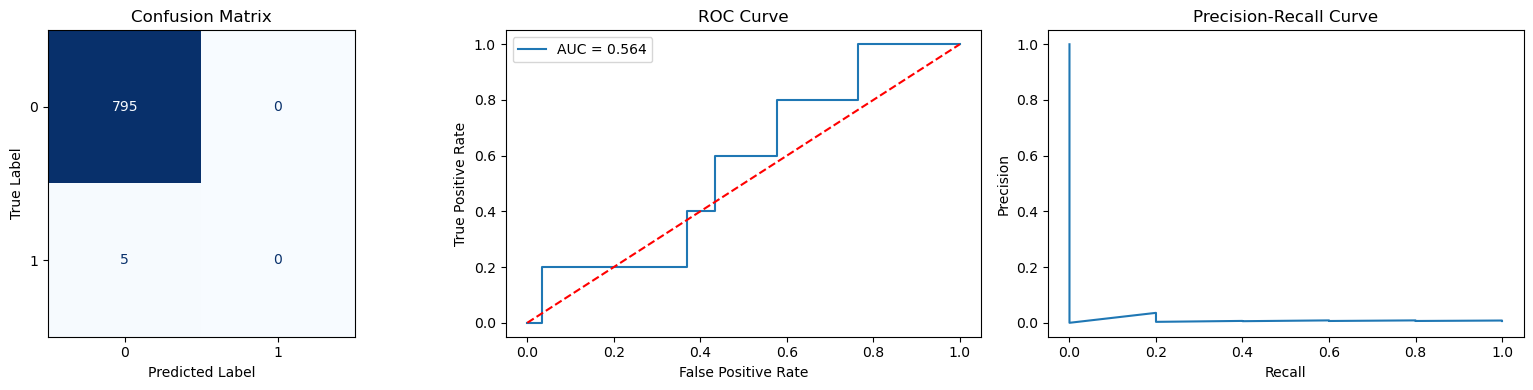

In [20]:
params3 = {'kernel': 'linear',
    'C': 1.0,
    'probability': True
}

X3_train, X3_test, y3_train, y3_test, model3 = split_scale(SVC, X3, y3, **params3)
results3 = run_classification_model(model3, X3_train, X3_test, y3_train, y3_test, confusion=True)